In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import googlemaps
from geopy.distance import geodesic
import json
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

home_address = 'YOUR_ADDRESS_HERE'  # Replace this with your address you want to calculate drive times from
max_drive_time = 30  # Replace this with your maximum drive time in minutes
min_score = 70 # Replace this with your min school score (0-100)
score_weight = 1.5  # Define your weight for the school score used in the ranking metric


In [4]:
# Check the webpage that lists all NC charter schools
url_schools = 'http://apps.schools.nc.gov/ords/f?p=125:1100'
response = requests.get(url_schools)

# Check if the request was successful
if response.status_code == 200:
    print("Successfully accessed the webpage that lists all NC charter schools.")
else:
    print(f"Failed to access the webpage that lists all NC charter schools. Status code: {response.status_code}")
    exit()


Successfully accessed the webpage that lists all NC charter schools.


In [5]:
# Parse the page content
soup = BeautifulSoup(response.content, 'html.parser')

# Looking for the table with id 'report_R2818899731761901215'
table_id = 'report_R2818899731761901215'
table = soup.find('table', {'id': table_id})

# Check if the table was successfully located
if table is None:
    print(f"Failed to locate the table with id '{table_id}'. Please check the page structure.")
    exit()
else:
    print(f"Successfully located the table with id '{table_id}'.")


Successfully located the table with id 'report_R2818899731761901215'.


In [6]:
# Initialize list to store the scraped data
data = []

# Extract school information from rows
rows = table.find_all('tr', class_='highlight-row')
if not rows:
    print("No data rows found in the table. The table might be empty or structured differently.")
else:
    print(f"Found {len(rows)} rows with data in the table.")

    for row in rows:
        cols = row.find_all('td')
        if len(cols) > 6:  # Ensure there are enough columns to parse
            school_name = row.find_previous('a').text.strip()
            school_url = row.find_previous('a')['href']
            director = cols[0].text.strip()
            board_chair = cols[1].text.strip()
            physical_address = cols[2].text.strip()
            current_grades = cols[3].text.strip()
            approved_grades = cols[4].text.strip()
            last_school_change_date = cols[5].text.strip()
            last_staff_change_date = cols[6].text.strip()

            # Append the extracted data to the list
            data.append({
                'School Name': school_name,
                'School URL': school_url,
                'Director': director,
                'Board Chair': board_chair,
                'Physical Address': physical_address,
                'Current Grades': current_grades,
                'Approved Grades': approved_grades,
                'Last School Change Date': last_school_change_date,
                'Last Staff Change Date': last_staff_change_date
            })

# Create the DataFrame (separate from export step)
if data:
    df = pd.DataFrame(data)
    print("DataFrame has been created successfully.")
    # Optionally display a sample of the data to verify
    print(df.head())
else:
    print("No data to create a DataFrame.")
    exit()

# Print to open in Data Wrangler    
print(df)

Found 214 rows with data in the table.
DataFrame has been created successfully.
                     School Name                                 School URL  \
0  Bonnie Cone Classical Academy               https://www.bccaschools.org/   
1                 A.C.E. Academy           http://www.aceacademycharter.org   
2                     ALA Monroe   https://www.alaschools.org/nc/monroe-k-8   
3    Achievement Charter Academy  https://www.achievementcharteracademy.org   
4      Alamance Community School   https://www.alamancecommunityschool.net/   

                                            Director  \
0  Mrs Pamela  Franklin \nE-mail: pamela.franklin...   
1  Laila  Minott \nE-mail: l.minott@aceacademycha...   
2  Deyonta   Thacker \nE-mail: deyonta.thacker@al...   
3  Leaja Hartman Horne \nE-mail: leaja@achievemen...   
4  Mrs Leslie Hall Paynter \nE-mail: lpaynter@ala...   

                                         Board Chair  \
0  Mr Marty  McCarthy \nE-mail: mmccarthy@bccasch...

In [7]:
# Filter the DataFrame to keep only rows where 'KG' is present in the 'Current Grades' column
df_filtered = df[df['Current Grades'].str.contains(':KG:01:02:03:04:05')]

# Step Display the filtered DataFrame to check the results
print(f"Filtered DataFrame has {len(df_filtered)} rows.")

# Print to open in Data Wrangler 
print(df_filtered)

Filtered DataFrame has 181 rows.
                                School Name  \
0             Bonnie Cone Classical Academy   
1                            A.C.E. Academy   
2                                ALA Monroe   
3               Achievement Charter Academy   
4                 Alamance Community School   
..                                      ...   
209              Wilson Preparatory Academy   
210             Winterville Charter Academy   
211                           Woods Charter   
212                     Youngsville Academy   
213  Z.E.C.A. School of Arts and Technology   

                                            School URL  \
0                         https://www.bccaschools.org/   
1                     http://www.aceacademycharter.org   
2             https://www.alaschools.org/nc/monroe-k-8   
3            https://www.achievementcharteracademy.org   
4             https://www.alamancecommunityschool.net/   
..                                                 ...

In [8]:
# Set up Google Maps API client
API_KEY = 'YOUR_API_KEY_HERE'  # Replace with your actual Google Maps API key
gmaps = googlemaps.Client(key=API_KEY)

# Define the city center
city_center_address = '600 East 4th Street Charlotte, NC 28202'  # Replace with your city center address

# Geocode the city center address to get its coordinates
city_center_location = gmaps.geocode(city_center_address)

if not city_center_location:
    print("Could not find the coordinates for the city center address.")
    exit()

city_center_coords = (
    city_center_location[0]['geometry']['location']['lat'], 
    city_center_location[0]['geometry']['location']['lng']
)
print(f"City center address coordinates: {city_center_coords}")

# Geocode school addresses, calculate distances, and filter by 25-mile radius
distances = []

for address in df_filtered['Physical Address']:
    try:
        # Geocode each school's physical address
        school_location = gmaps.geocode(address)
        if school_location:
            school_coords = (
                school_location[0]['geometry']['location']['lat'],
                school_location[0]['geometry']['location']['lng']
            )
            # Calculate distance in miles from the city center to the school
            distance = geodesic(city_center_coords, school_coords).miles
        else:
            distance = None  # If geocoding fails, set distance to None
    except Exception as e:
        print(f"Error calculating distance for address {address}: {e}")
        distance = None

    distances.append(distance)

# Add the 'Distance' column to the DataFrame
df_filtered['Distance (mi)'] = distances

# Filter schools within 25 miles of the city center
df_filtered = df_filtered[df_filtered['Distance (mi)'] <= 25]

# Print to open in Data Wrangler 
print(df_filtered)

City center address coordinates: (35.2213613, -80.8394223)
                                   School Name  \
0                Bonnie Cone Classical Academy   
1                               A.C.E. Academy   
2                                   ALA Monroe   
7        American Leadership Academy Charlotte   
21              Bonnie Cone Leadership Academy   
22                 Bradford Preparatory School   
29               Carolina International School   
35                        Charlotte Lab School   
44                    Community Public Charter   
45                Community School of Davidson   
47                  Concord Lake STEAM Academy   
49                    Corvian Community School   
56           East Voyager Academy of Charlotte   
82                          Jackson Day School   
84                              KIPP Charlotte   
90                         Lake Norman Charter   
91                    Lakeside Charter Academy   
92                    Langtree Charter Ac

/var/folders/29/vd7p76zn2qsgxg1hstslwvz80000gn/T/ipykernel_28969/3492229722.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Distance (mi)'] = distances


In [9]:
# Calculate driving time from the home address to each school
drive_times = []

for address in df_filtered['Physical Address']:
    try:
        # Use Google Maps Distance Matrix API to calculate driving time
        drive_time_result = gmaps.distance_matrix(home_address, address, mode="driving")

        if drive_time_result['rows'][0]['elements'][0]['status'] == 'OK':
            # Extract the driving time in minutes
            drive_time = drive_time_result['rows'][0]['elements'][0]['duration']['value'] / 60
        else:
            drive_time = None  # If Google Maps cannot find a route
    except Exception as e:
        print(f"Error calculating drive time for address {address}: {e}")
        drive_time = None

    drive_times.append(drive_time)

# Add the 'Drive Time' column to the DataFrame
df_filtered['Drive Time (min)'] = drive_times

# Print to open in Data Wrangler 
print(df_filtered)

                                   School Name  \
0                Bonnie Cone Classical Academy   
1                               A.C.E. Academy   
2                                   ALA Monroe   
7        American Leadership Academy Charlotte   
21              Bonnie Cone Leadership Academy   
22                 Bradford Preparatory School   
29               Carolina International School   
35                        Charlotte Lab School   
44                    Community Public Charter   
45                Community School of Davidson   
47                  Concord Lake STEAM Academy   
49                    Corvian Community School   
56           East Voyager Academy of Charlotte   
82                          Jackson Day School   
84                              KIPP Charlotte   
90                         Lake Norman Charter   
91                    Lakeside Charter Academy   
92                    Langtree Charter Academy   
94                      Lincoln Charter School   


In [10]:
# Check the webpage that lists all NC school grades and score
url_grades = 'https://ncreports.ondemand.sas.com/src/'
response = requests.get(url_grades)

# Check if the request was successful
if response.status_code == 200:
    print("Successfully accessed the webpage that lists all NC school grades and score.")
else:
    print(f"Failed to access the webpage that lists all NC school grades and score. Status code: {response.status_code}")
    exit()


Successfully accessed the webpage that lists all NC school grades and score.


In [11]:
# Parse the webpage content using BeautifulSoup to find the JSON data
soup = BeautifulSoup(response.content, 'html.parser')
script_tag = soup.find('script', {'id': '__NEXT_DATA__'})  # Locate the script with the JSON data

if script_tag:
    # Load the JSON data
    json_data = json.loads(script_tag.string)

    # Extract the relevant data (spg_score and spg_grade for each school)
    all_schools_data = json_data['props']['pageProps']['filters']['allschoolsCurrYear']

    # Create lists to store extracted spg_score and spg_grade
    school_grades = {}
    for school in all_schools_data:
        school_name = school['School_Name']
        spg_score = school.get('spg_score', None)
        spg_grade = school.get('spg_grade', None)
        
        # Store the grades and scores in a dictionary
        school_grades[school_name] = {
            'SPG Score': spg_score,
            'SPG Grade': spg_grade
        }

    # Step 10: Map these grades and scores to the existing DataFrame
    df_filtered['SPG Score'] = df_filtered['School Name'].map(lambda name: school_grades.get(name, {}).get('SPG Score', None))
    df_filtered['SPG Grade'] = df_filtered['School Name'].map(lambda name: school_grades.get(name, {}).get('SPG Grade', None))

    # Display the updated DataFrame with new columns
    print("Updated DataFrame with SPG Scores and Grades:")
    print(df_filtered.head())
else:
    print("Could not locate the '__NEXT_DATA__' script tag containing the school grades data.")

# Remove rows where 'SPG Score' or 'SPG Grade' is missing (NaN)
df_filtered = df_filtered.dropna(subset=['SPG Score', 'SPG Grade'])

# Print to open in Data Wrangler 
print(df_filtered)

Updated DataFrame with SPG Scores and Grades:
                              School Name  \
0           Bonnie Cone Classical Academy   
1                          A.C.E. Academy   
2                              ALA Monroe   
7   American Leadership Academy Charlotte   
21         Bonnie Cone Leadership Academy   

                                  School URL  \
0               https://www.bccaschools.org/   
1           http://www.aceacademycharter.org   
2   https://www.alaschools.org/nc/monroe-k-8   
7           www.alaschools.org/charlotte-k-6   
21     https://www.bonniecone.org/leadership   

                                             Director  \
0   Mrs Pamela  Franklin \nE-mail: pamela.franklin...   
1   Laila  Minott \nE-mail: l.minott@aceacademycha...   
2   Deyonta   Thacker \nE-mail: deyonta.thacker@al...   
7   Mrs Carmie  Green \nE-mail: carmi.green@alacha...   
21  Mr Ramon  Richardson \nE-mail: ramon.richardso...   

                                          Board Cha

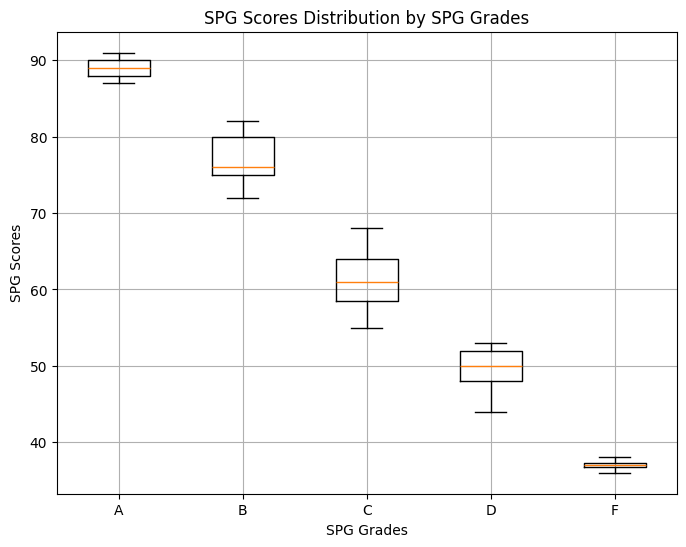

In [12]:
# Confirm Grades classify Scores as expected
# Ensure SPG Grade is treated as a categorical variable
df_filtered['SPG Grade'] = pd.Categorical(df_filtered['SPG Grade'], categories=['A', 'B', 'C', 'D', 'F'], ordered=True)

# Plot the SPG Score distribution across the different SPG Grades
plt.figure(figsize=(8, 6))
plt.boxplot([df_filtered[df_filtered['SPG Grade'] == grade]['SPG Score'] for grade in ['A', 'B', 'C', 'D', 'F']], labels=['A', 'B', 'C', 'D', 'F'])

plt.title("SPG Scores Distribution by SPG Grades")
plt.xlabel("SPG Grades")
plt.ylabel("SPG Scores")
plt.grid(True)
plt.show()


In [13]:
# Filter out rows where SPG Grade is 'D' or 'F'
df_filtered = df_filtered[~df_filtered['SPG Grade'].isin(['D', 'F'])]

# Print to open in Data Wrangler 
print(df_filtered)

                                   School Name  \
22                 Bradford Preparatory School   
29               Carolina International School   
44                    Community Public Charter   
45                Community School of Davidson   
47                  Concord Lake STEAM Academy   
49                    Corvian Community School   
56           East Voyager Academy of Charlotte   
82                          Jackson Day School   
90                         Lake Norman Charter   
92                    Langtree Charter Academy   
94                      Lincoln Charter School   
96                  Mallard Creek STEM Academy   
98                    Matthews Charter Academy   
100        Metrolina Regional Scholars Academy   
106         Mountain Island Charter School Inc   
108                   Movement School Eastland   
127          Piedmont Community Charter School   
128                Pine Lake Preparatory, Inc.   
136             Queen's Grant Community School   


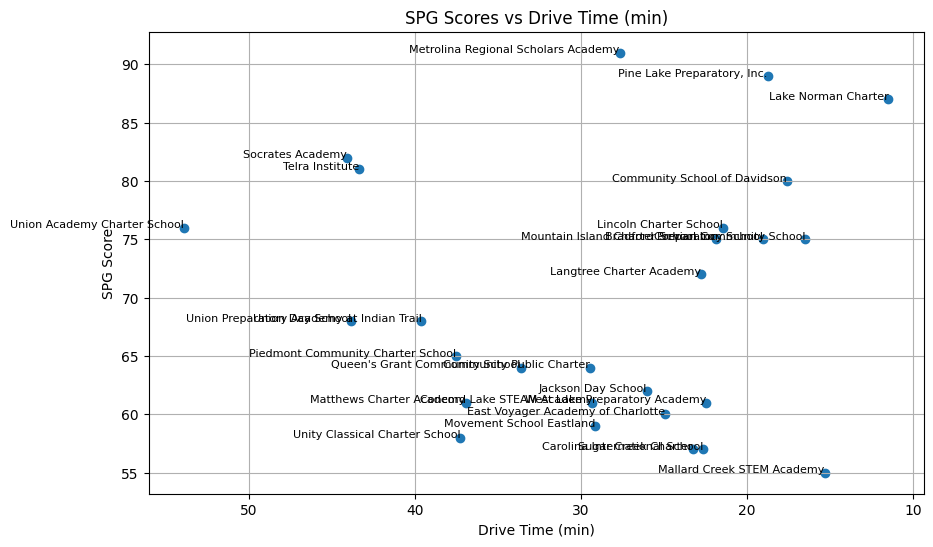

In [14]:
# Using 'SPG Score', 'Drive Time (min)', and 'School Name' from df_filtered
plt.figure(figsize=(10, 6))

# Scatter plot of SPG Score vs Drive Time
plt.scatter(df_filtered['Drive Time (min)'], df_filtered['SPG Score'])

# Reverse the x-axis (Drive Time)
plt.gca().invert_xaxis()

# Add labels for each point
for i, row in df_filtered.iterrows():
    plt.text(row['Drive Time (min)'], row['SPG Score'], row['School Name'], fontsize=8, ha='right')

# Set titles and labels
plt.title('SPG Scores vs Drive Time (min)')
plt.xlabel('Drive Time (min)')
plt.ylabel('SPG Score')

plt.grid(True)
plt.show()


In [15]:
# Filter the DataFrame based on plot above
df_filtered = df_filtered[
    (df_filtered['Drive Time (min)'] <= max_drive_time) &  # Drive time is less than or equal to max_drive_time
    (df_filtered['SPG Score'] >= min_score)                # SPG Score is greater than or equal to min_score
]

# Print to open in Data Wrangler 
print(df_filtered)

                             School Name                      School URL  \
22           Bradford Preparatory School     http://www.bradfordprep.org   
45          Community School of Davidson      http://www.csdspartans.org   
49              Corvian Community School          http://www.corvian.org   
90                   Lake Norman Charter        http://www.lncharter.org   
92              Langtree Charter Academy  http://www.langtreecharter.org   
94                Lincoln Charter School  http://www.lincolncharter.org/   
100  Metrolina Regional Scholars Academy  http://www.scholarsacademy.org   
106   Mountain Island Charter School Inc        http://www.micharter.org   
128          Pine Lake Preparatory, Inc.     http://www.pinelakeprep.org   

                                              Director  \
22   Stephen  Gay \nE-mail: stephen.gay@bradfordpre...   
45   Mr Craig  Smith \nE-mail: cssmith@csdspartans.org   
49   Mrs Nicki  Sinclair \nE-mail: nicki.sinclair@c...   
90     

In [16]:
# Normalize the Drive Time (min) and SPG Score columns to a scale between 0 and 1
df_filtered['Normalized Drive Time'] = (df_filtered['Drive Time (min)'] - df_filtered['Drive Time (min)'].min()) / (df_filtered['Drive Time (min)'].max() - df_filtered['Drive Time (min)'].min())
df_filtered['Normalized SPG Score'] = (df_filtered['SPG Score'] - df_filtered['SPG Score'].min()) / (df_filtered['SPG Score'].max() - df_filtered['SPG Score'].min())

# Weight the SPG Score by the score_weight variable
df_filtered['Rank Metric'] = (score_weight * df_filtered['Normalized SPG Score']) + df_filtered['Normalized Drive Time']

# Normalize the Rank Metric to a scale between 0 and 1
df_filtered['Normalized Rank Metric'] = (df_filtered['Rank Metric'] - df_filtered['Rank Metric'].min()) / (df_filtered['Rank Metric'].max() - df_filtered['Rank Metric'].min())

# Rank the schools by the new 'Rank Metric' (higher is better)
df_filtered['Rank'] = df_filtered['Rank Metric'].rank(ascending=False)

# Sort the DataFrame by the Rank Metric
df_filtered = df_filtered.sort_values(by='Rank Metric', ascending=False)

# Print to open in Data Wrangler 
print(df_filtered)

                             School Name                      School URL  \
100  Metrolina Regional Scholars Academy  http://www.scholarsacademy.org   
128          Pine Lake Preparatory, Inc.     http://www.pinelakeprep.org   
90                   Lake Norman Charter        http://www.lncharter.org   
45          Community School of Davidson      http://www.csdspartans.org   
94                Lincoln Charter School  http://www.lincolncharter.org/   
106   Mountain Island Charter School Inc        http://www.micharter.org   
22           Bradford Preparatory School     http://www.bradfordprep.org   
92              Langtree Charter Academy  http://www.langtreecharter.org   
49              Corvian Community School          http://www.corvian.org   

                                              Director  \
100  Mr Chad  Carper \nE-mail: Director@scholarsaca...   
128  Mr Andrew  Moceri \nE-mail: andrew.moceri@pine...   
90       Shannon  Stein \nE-mail: sstein@lncharter.org   
45   Mr

In [17]:
# Reorder and rename the specified columns
df_filtered = df_filtered[[
    'Rank', 'Rank Metric', 'Normalized Rank Metric', 'School Name', 'SPG Score', 'Normalized SPG Score',
    'Drive Time (min)', 'Normalized Drive Time', 'Current Grades', 'School URL', 'Physical Address'
]]

# Export the DataFrame to a CSV file
df_filtered.to_csv('ranked_schools_filtered.csv', index=False)

# Print a message to confirm export
print("The filtered and reordered DataFrame has been saved to 'ranked_schools_filtered.csv'.")
# Print to open in Data Wrangler 
print(df_filtered)

The filtered and reordered DataFrame has been saved to 'ranked_schools_filtered.csv'.
     Rank  Rank Metric  Normalized Rank Metric  \
100   1.0     2.500000                1.000000   
128   2.0     1.790665                0.637079   
90    3.0     1.184211                0.326795   
45    4.0     1.010180                0.237755   
94    5.0     0.929987                0.196725   
106   6.0     0.876760                0.169492   
22    7.0     0.702891                0.080535   
92    8.0     0.697531                0.077793   
49    9.0     0.545484                0.000000   

                             School Name  SPG Score  Normalized SPG Score  \
100  Metrolina Regional Scholars Academy       91.0              1.000000   
128          Pine Lake Preparatory, Inc.       89.0              0.894737   
90                   Lake Norman Charter       87.0              0.789474   
45          Community School of Davidson       80.0              0.421053   
94                Lincoln Ch

In [18]:
# Create a PDF file to save the plots
with PdfPages('school_plots.pdf') as pdf:

    # Plot 1: Schools ordered by highest rank metric (x) vs normalized rank metric (y)
    df_filtered_sorted_by_rank_metric = df_filtered.sort_values(by='Rank Metric', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(df_filtered_sorted_by_rank_metric['School Name'], df_filtered_sorted_by_rank_metric['Normalized Rank Metric'])
    plt.xticks(rotation=90, fontsize=8)
    plt.title("Schools by Normalized Rank Metric (Highest to Lowest)")
    plt.xlabel("Schools")
    plt.ylabel("Normalized Rank Metric")
    plt.tight_layout()
    pdf.savefig()  # Save the figure to the PDF
    plt.close()

    # Plot 2: Schools ordered by highest score (x) vs normalized score (y)
    df_filtered_sorted_by_score = df_filtered.sort_values(by='SPG Score', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(df_filtered_sorted_by_score['School Name'], df_filtered_sorted_by_score['Normalized SPG Score'])
    plt.xticks(rotation=90, fontsize=8)
    plt.title("Schools by Normalized Score (Highest to Lowest)")
    plt.xlabel("Schools")
    plt.ylabel("Normalized Score")
    plt.tight_layout()
    pdf.savefig()  # Save the figure to the PDF
    plt.close()

    # Plot 3: Schools ordered by lowest drive time (x) vs normalized drive time (y)
    df_filtered_sorted_by_drive_time = df_filtered.sort_values(by='Drive Time (min)', ascending=True)
    plt.figure(figsize=(10, 6))
    plt.bar(df_filtered_sorted_by_drive_time['School Name'], df_filtered_sorted_by_drive_time['Normalized Drive Time'])
    plt.xticks(rotation=90, fontsize=8)
    plt.title("Schools by Normalized Drive Time (Lowest to Highest)")
    plt.xlabel("Schools")
    plt.ylabel("Normalized Drive Time")
    plt.tight_layout()
    pdf.savefig()  # Save the figure to the PDF
    plt.close()

print("The PDF containing the plots has been saved as 'school_plots.pdf'.")


The PDF containing the plots has been saved as 'school_plots.pdf'.
